<h1> Задание по Uplift-моделированию </h1>

<h2>Введение</h2>

Перед вами типичная задача, возникающая при работе с моделями кампейнинга в банке: заказчик запустил несколько пилотов по взаимодействию с клиентами с помощью разных каналов: push в мобильном приложении, sms, баннеры в мобильном приложении и реклама в других приложениях экосистемы. Заказчик хотел бы понимать, какой канал взаимодействия с клиентом наиболее эффективен для каждого клиента из клиентской базы. Кампании планируются и запускаются в ежемесячном режиме. Иными словами, заказчик хотел бы в идеале ежемесячно получать список клиентов, которым необходимо отправить коммуникацию с указанием канала и прироста вероятности покупки в случае, если клиенту отправят коммуникацию по сравнению с тем случаем, когда клиенту коммуникацию не отправят.

<b>Таким образом: </b>
1.	У нас есть база клиентов (клиенты, имеющие id в банке). По данной базе осуществляется рассылка тех или иных стимулирующих коммуникаций по различным продуктам, каналам (например SMS, Push, баннеры в мобильном приложении и т.д.) и сегментам клиентов
2.	Признаковое описание клиента состоит из различных агрегатов действий клиента за месяц или его объективных характеристик: например, средняя сумма средств на депозитах за месяц, среднее число кликов клиента в день за месяц в разделе "инвестиции" в мобильном приложении или возраст клиента
3.	При формировании обучающей/тестовой выборки допускается, что один и тот же клиент за разные месяцы — это разные объекты. То есть допускается, что клиент в феврале и клиент в марте — это разные клиенты (то есть мы можем оперировать с ними как с разными сущностями).
4.	Агрегаты действий клиента за месяц появляются примерно 10 числа следующего месяца. То есть, например, агрегаты за декабрь появляются 10 января. В свою очередь списки клиентов, которым необходимо осуществить рассылку должны быть сформированы ориентировочно 20 числа предыдущего месяца. Таким образом, <b> модель должна быть обучена делать предсказания с лагом в два месяца </b>, то есть должна делать предсказание на март по клиентским агрегатам за январь. Обязательно учтите это при обучении модели (в противном случае можно получить лик таргета, так как часто величину, которую мы предсказываем уже есть в клиентских агрегатах, но смещенная на два месяца).


## Оценивание задания:

Всего за задание можно получить 50 первичных баллов, которые затем переводятся в 10-балльную шкалу делением не 5.

Скачаем архив с данными по ссылке и разархивируем.

In [1]:
!pip install gdown -q

In [2]:
import gdown

url = 'https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO'
output = 'Data.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO
From (redirected): https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO&confirm=t&uuid=d40fffe5-33f7-404b-a53b-74821880df1e
To: /content/Data.zip
100%|██████████| 289M/289M [00:03<00:00, 72.6MB/s]


'Data.zip'

In [3]:
import zipfile

with zipfile.ZipFile('Data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

<h2>Описание данных</h2>

Перед вами несколько наборов данных, на основе которых вам будет необходимо обучить Uplift модели, сделать прогноз на нужный месяц и решить, кому из клиентов отправлять коммуникацию, а кому коммуникацию отправлять не следует.

<h3>Features </h3> Признаки клиентов, клиентские агрегаты, которые описывают поведение клиентов <br>

1. user_id - id клиента
2. report_dt - месяц, на который актуальны признаки
3. city - город, в котором живет клиент
4. age - возраст клиента
5. x1 – x9 - числовые признаки клиента, характеризующие поведение клиента

Первичный ключ таблицы - user_id + report_dt

<h3> Contracts </h3> Таблица с покупками продуктов.

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


<h3> Campaings </h3> Кампании, которые проводились (под кампанией мы понимаем рассылку sms, push и т.д).

1. campaing_id - id кампании, первичный ключ таблицы
2. product_id - продукт, по которому проводилась кампания (считаем, что продукты не конкурируют друг с другом)
3. channel - канал, в котором проводилась кампания


<h3> People_in_campaings </h3> Люди, которые принимали участие в кампаниях.

1. campaing_id - id кампании
2. user_id - id пользователя, который попал в кампанию
3. флаг целевой (1) и контрольной (0) группы (целевая группа - это те, кто получил коммуникацию, а контрольная - те, кто нет)
4. delivery_ts - timestamp, когда клиенту фактически была доставлена коммуникация (для контрольной группы nan, подумайте почему)

Первичный ключ данной таблицы - user_id + campaing_id


<h1> Постановка задачи </h1> В ноябре 2024 проводилось несколько кампаний по продукту с id 0001 (фактически клиенту рассылалось одно и тоже сообщение, но в разных каналах). Вам необходимо по данным кампаниям построить модель, которая будет определять лучший канал коммуникации каждого клиента и определить, кому из клиентов в марте 2025 отправить какую коммуникацию, а кому коммуникацию вообще отправлять не следует.
Ответ нужно представить в следующем виде (report_dt – дата фичей):

<table>
  <thead>
    <tr>
      <th>user_id</th>
      <th>report_dt</th>
      <th>channel</th>
      <th>uplift</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>10045</td>
      <td>2025-01-31</td>
      <td>banner</td>
      <td>0.07</td>
    </tr>
    <tr>
      <td>10046</td>
      <td>2025-01-31</td>
      <td>no_comm</td>
      <td>0.00</td>
    </tr>
    <tr>
      <td>10047</td>
      <td>2025-01-31</td>
      <td>sms</td>
      <td>0.23</td>
    </tr>
    <tr>
      <td>10048</td>
      <td>2025-01-31</td>
      <td>push</td>
      <td>0.19</td>
    </tr>
  </tbody>
</table>

<h1> Декомпозиция задачи </h1>

## <h2> 1.	Сбор и анализ таргета (18 баллов)</h2>

Прежде всего, вам необходимо собрать целевое событие, которое вы собираетесь прогнозировать. В данном случае целевое событие - это покупка продукта 0001 пользователем, участвовавшем в кампании. Обратите внимание, что не все пользователи получают коммуникацию одновременно (delivery_ts в таблице People_in_campaings). Согласно правилу, согласованному с заказчиком, <b> человек из целевой группы купил продукт после коммуникации - это значит, что он купил его в течение 2х недель после получения сообщения, а человек из контрольной - в течение 3х недель с момента старта кампании (старт кампании - начало месяца). </b> То есть для определенной кампании, для каждого клиента, попавшего в кампанию, вам надо будет найти его покупки данного продукта, а потом основываяся на данном правиле превратить покупки в 0 или 1. <br> На выходе у вас должен появиться таблица с целевым действием для каждого канала (колонки client_id, report_dt,  target), где таргет - это бинарная переменная (0 или 1). Колонка report_dt вам нужна как техническая колонка для дальнейших джоинов.<br><br>

Проведите анализ полученных данных (до присоединения клиентских агрегатов). Какие проблемы и сложности в данных вы обнаружили? Что с ними можно сделать? Какая из кампаний наиболее эффективная? Подготовьте выводы по полученным инсайтам.


**Комментарий по заданиям и оцениванию:**

* Вы должны самостоятельно сделать join нескольких таблиц, самостоятельно собрать целевое действие

* Представлены 4 различных канала, за таргет по каждому из каналов можно получить **максимум 2 балла**:
    * 1 балл за то, что просчитано целевое действие для целевой группы (покупка в
течение одной-двух недель с момента получения коммуникации)
    * 1 балл за то, что просчитано целевое действие для контрольной группы (покупка в течение двух-трех недель с момента старта кампании) и сделана таблица в требуемом формате

* Обратите внимание, что не во всех кампаниях содержатся корректные данные для проведения моделирования, и вам необходимо провести анализ данных и в случае выявленных некорректностей - описать их, и не проводить моделирование для "сломанной" кампании  
    * За данный анализ можно получить **8 баллов**

* Вы должны оценить эффективность кампаний по uplift (cреднее значение таргета в целевой минус среднее значение таргета в контрольной группе)
    * За данный анализ можно получить **2 балла**

### Пункт 1

In [4]:
import pandas as pd

In [5]:
!cp -r 'ДЗ по Uplift обновленное'/* ./

In [6]:
!ls -la

total 875640
drwxr-xr-x 1 root root      4096 Feb 26 17:49  .
drwxr-xr-x 1 root root      4096 Feb 26 17:46  ..
-rw-r--r-- 1 root root 577232030 Feb 26 17:49  AGGS_FINAL.csv
-rw-r--r-- 1 root root       110 Feb 26 17:49  CAMPAINGS.csv
drwxr-xr-x 4 root root      4096 Feb 25 14:21  .config
-rw-r--r-- 1 root root  14343865 Feb 26 17:49  CONTRACTS_FINAL.csv
-rw-r--r-- 1 root root 288959007 Feb 18 13:35  Data.zip
-rw-r--r-- 1 root root  16082828 Feb 26 17:49  PEOPLE_IN_CAMPAINGS_FINAL.csv
drwxr-xr-x 1 root root      4096 Feb 25 14:21  sample_data
drwxr-xr-x 2 root root      4096 Feb 26 17:48 'ДЗ по Uplift обновленное'


Файлы есть, можно приступить к работе

In [7]:
people_df = pd.read_csv('PEOPLE_IN_CAMPAINGS_FINAL.csv', index_col=0)
campaigns_df = pd.read_csv('CAMPAINGS.csv', index_col=0)
contracts_df = pd.read_csv('CONTRACTS_FINAL.csv', index_col=0)
aggs_df = pd.read_csv('AGGS_FINAL.csv', index_col=0)

In [8]:
people_df.head()

,campaing_id,user_id,t_flag,delivery_date
29299,idclip,1099975,1,2024-11-06
36627,iddqd,1162,1,2024-11-08
134015,iddqd,42991,1,2024-11-07
57441,idclip,142343,0,unknown
48671,iddqd,24623,0,unknown


In [13]:
people_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 520000 entries, 29299 to 148522
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   campaing_id    520000 non-null  object
 1   user_id        520000 non-null  int64 
 2   t_flag         520000 non-null  int64 
 3   delivery_date  520000 non-null  object
dtypes: int64(2), object(2)
memory usage: 19.8+ MB


Столбцы названы иначе, чем в описании задания

In [9]:
campaigns_df.head()

,campaing_id,product_id,channel
0,iddqd,1,push
1,idclip,1,sms
2,iddt,1,banner
3,idkfa,1,other_ads


In [14]:
campaigns_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   campaing_id  4 non-null      object
 1   product_id   4 non-null      int64 
 2   channel      4 non-null      object
dtypes: int64(1), object(2)
memory usage: 128.0+ bytes


In [10]:
contracts_df.head()

,user_id,contract_date,product_id,contract_id
39735,4008279,2024-11-03,1,0001_2024-11-03_4008279
44062,2079035,2024-11-08,1,0001_2024-11-08_2079035
9286,103088,2024-11-13,1,0001_2024-11-13_103088
45573,2026788,2024-11-02,1,0001_2024-11-02_2026788
150378,52269,2024-11-17,1,0001_2024-11-17_52269


In [12]:
contracts_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 286316 entries, 39735 to 30945
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        286316 non-null  int64 
 1   contract_date  286316 non-null  object
 2   product_id     286316 non-null  int64 
 3   contract_id    286316 non-null  object
dtypes: int64(2), object(2)
memory usage: 10.9+ MB


In [11]:
aggs_df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,report_dt,user_id,age,city
104548,0.654343,-1.439286,-0.011475,2.039457,0.843580,-0.977480,-0.768019,-1.044127,0.025673,2025-01-31,1066338,26,Ufa
38396,2.583579,1.755569,3.360186,-1.122864,0.034201,-0.269607,-1.503646,1.040289,-1.691606,2024-11-30,13900,35,Ufa
227077,0.296030,-0.937075,1.073280,1.874636,-0.981216,-1.100187,-0.331181,-1.575637,0.474965,2025-03-31,4063636,28,Ufa
304649,2.329328,-1.345159,0.345066,0.755373,-0.082842,0.028439,0.919211,0.808793,-0.560004,2025-03-31,1025488,27,Moscow
239518,0.167643,1.587099,0.165357,0.289758,-1.108840,-1.501819,0.615588,1.631203,-0.208419,2025-02-28,4040555,37,Moscow


In [15]:
aggs_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2760000 entries, 104548 to 454256
Data columns (total 13 columns):
 #   Column     Dtype  
---  ------     -----  
 0   x1         float64
 1   x2         float64
 2   x3         float64
 3   x4         float64
 4   x5         float64
 5   x6         float64
 6   x7         float64
 7   x8         float64
 8   x9         float64
 9   report_dt  object 
 10  user_id    int64  
 11  age        int64  
 12  city       object 
dtypes: float64(9), int64(2), object(2)
memory usage: 294.8+ MB


In [ ]:
# Приведем столбец 'delivery_date' к формату datetime, чтобы 'unknown' стали NaT
people_df['delivery_date'] = pd.to_datetime(people_df['delivery_date'], errors='coerce')
people_df.head()

,campaing_id,user_id,t_flag,delivery_date
29299,idclip,1099975,1,2024-11-06
36627,iddqd,1162,1,2024-11-08
134015,iddqd,42991,1,2024-11-07
57441,idclip,142343,0,NaT
48671,iddqd,24623,0,NaT


In [ ]:
# Фильтруем кампании по целевому продукту
# В условии указано продукт '0001', но product_id равен "1"
target_product = 1
campaigns_target = campaigns_df[campaigns_df['product_id'] == target_product]
campaigns_target.head()

,campaing_id,product_id,channel
0,iddqd,1,push
1,idclip,1,sms
2,iddt,1,banner
3,idkfa,1,other_ads


In [ ]:
# Объединяем таблицы по campaing_id
merged_df = pd.merge(people_df, campaigns_target, on='campaing_id', how='inner')

In [ ]:
# Отбор участников кампании, проведённых в ноябре 2024:
# Для целевой группы (t_flag == 1) проверяем, что дата доставки (delivery_date) попадает в ноябрь 2024.
target_group = merged_df[
    (merged_df['t_flag'] == 1) &
    (merged_df['delivery_date'].notnull()) &
    (merged_df['delivery_date'].dt.year == 2024) &
    (merged_df['delivery_date'].dt.month == 11)
]

In [ ]:
# Для контрольной группы (t_flag == 0) дата доставки отсутствует (NaT), но
# предполагается, что кампания стартовала в ноябре 2024, поэтому оставляем их без дополнительной фильтрации.
control_group = merged_df[merged_df['t_flag'] == 0]

# Объединяем группы для дальнейшей работы
campaign_data_nov = pd.concat([target_group, control_group], ignore_index=True)

In [ ]:
# Выводим первые строки для проверки
campaign_data_nov.head()

,campaing_id,user_id,t_flag,delivery_date,product_id,channel
0,idclip,1099975,1,2024-11-06,1,sms
1,iddqd,1162,1,2024-11-08,1,push
2,iddqd,42991,1,2024-11-07,1,push
3,idkfa,2008409,1,2024-11-04,1,other_ads
4,iddt,4045746,1,2024-11-04,1,banner


In [ ]:
campaign_data_nov.shape

(520000, 6)

In [ ]:
# Рассчитаем долю некорректных дат (NaT) для целевой группы
target_group = campaign_data_nov[campaign_data_nov['t_flag'] == 1]
missing_delivery_ratio = target_group['delivery_date'].isna().mean()

print("Доля отсутствующих delivery_date в целевой группе:", missing_delivery_ratio)

Доля отсутствующих delivery_date в целевой группе: 0.0


In [ ]:
# Выведем уникальные месяцы для дат доставки из целевой группы
unique_delivery_months = target_group['delivery_date'].dropna().dt.to_period('M').unique()
print("Уникальные месяцы delivery_date в целевой группе:", unique_delivery_months)

Уникальные месяцы delivery_date в целевой группе: <PeriodArray>
['2024-11']
Length: 1, dtype: period[M]


In [ ]:
# Группировка по каналу и группе для расчёта среднего таргета
grouped_stats = campaign_data_nov.groupby(['channel', 't_flag'])['target'].mean().reset_index()
print("Статистика таргета по каналам и группам:")
print(grouped_stats)

Статистика таргета по каналам и группам:
     channel  t_flag    target
0     banner       0  0.400733
1     banner       1  0.602717
2  other_ads       0  0.400733
3  other_ads       1  0.602717
4       push       0  0.202150
5       push       1  0.601738
6        sms       0  0.684917
7        sms       1  0.201167


### Пункт 2

In [ ]:
import pandas as pd
from datetime import timedelta

In [ ]:
contracts_df.head()

,user_id,contract_date,product_id,contract_id
39735,4008279,2024-11-03,1,0001_2024-11-03_4008279
44062,2079035,2024-11-08,1,0001_2024-11-08_2079035
9286,103088,2024-11-13,1,0001_2024-11-13_103088
45573,2026788,2024-11-02,1,0001_2024-11-02_2026788
150378,52269,2024-11-17,1,0001_2024-11-17_52269


In [ ]:
contracts_df['contract_date'] = pd.to_datetime(contracts_df['contract_date'], errors='coerce')

In [ ]:
def check_purchase(row):
    """
    Функция для определения наличия покупки в нужном временном окне
    """
    user = row['user_id']
    product = row['product_id']  # В выборке product_id должно совпадать с целевым (например, "1")

    # Определяем окно для покупки в зависимости от группы
    if row['t_flag'] == 1:
        # Для целевой группы окно: с момента доставки до +14 дней
        start_date = row['delivery_date']
        end_date = start_date + timedelta(days=14)
    else:
        # Для контрольной группы окно: с 1 ноября 2024 до +21 дня
        start_date = pd.Timestamp('2024-11-01')
        end_date = start_date + timedelta(days=21)

    # Отбираем покупки для данного пользователя и продукта
    user_contracts = contracts_df[(contracts_df['user_id'] == user) &
                                  (contracts_df['product_id'] == product)]

    if user_contracts.empty:
        return 0  # Покупки не найдены

    # Проверяем, была ли покупка в заданном окне
    purchase = user_contracts[(user_contracts['contract_date'] >= start_date) &
                              (user_contracts['contract_date'] <= end_date)]
    return 1 if not purchase.empty else 0

In [ ]:
from tqdm import tqdm

In [ ]:
tqdm.pandas()

In [ ]:
# Применяем функцию к DataFrame с данными кампании (campaign_data_nov)
# Предполагается, что campaign_data_nov сформирован на предыдущем этапе и содержит колонки:
# 'user_id', 't_flag', 'delivery_date', 'product_id' и 'channel'
campaign_data_nov['target'] = campaign_data_nov.progress_apply(check_purchase, axis=1)

100%|██████████| 520000/520000 [16:10<00:00, 536.08it/s]


In [ ]:
# Добавляем техническую колонку report_dt (например, дата старта кампании)
campaign_data_nov['report_dt'] = '2024-11-01'

# Формируем итоговую таблицу с нужными колонками: client_id, report_dt, target и channel (для анализа)
target_table = campaign_data_nov[['user_id', 'report_dt', 'target', 'channel']].rename(
    columns={'user_id': 'client_id'}
)

In [ ]:
target_table.head()

,client_id,report_dt,target,channel
0,1099975,2024-11-01,1,sms
1,1162,2024-11-01,1,push
2,42991,2024-11-01,0,push
3,2008409,2024-11-01,0,other_ads
4,4045746,2024-11-01,0,banner


In [ ]:
# Сохранение файлов для ускорения работы (в случае перезапуска)
campaign_data_nov.to_csv('campaign_data_nov.csv')
target_table.to_csv('target_table.csv')

### Пункт 3

In [ ]:
# Рассчитаем среднее значение таргета для каждого канала (общая эффективность)
channel_avg = campaign_data_nov.groupby('channel')['target'].mean().reset_index()
print("Среднее значение таргета по каналам:")
channel_avg.round(3)

Среднее значение таргета по каналам:


,channel,target
0,banner,0.502
1,other_ads,0.502
2,push,0.402
3,sms,0.443


In [ ]:
# Рассчитаем среднее значение таргета отдельно для контрольной (t_flag == 0)
# и целевой (t_flag == 1) групп для каждого канала
channel_group_stats = campaign_data_nov.groupby(['channel', 't_flag'])['target'].mean().reset_index()
print("Среднее значение таргета по каналам для каждой группы:")
channel_group_stats.round(3)

Среднее значение таргета по каналам для каждой группы:


,channel,t_flag,target
0,banner,0,0.401
1,banner,1,0.603
2,other_ads,0,0.401
3,other_ads,1,0.603
4,push,0,0.202
5,push,1,0.602
6,sms,0,0.685
7,sms,1,0.201


In [ ]:
# Пивотируем таблицу, чтобы получить колонки с результатами для контрольной и целевой групп
pivot_stats = channel_group_stats.pivot(index='channel', columns='t_flag', values='target').reset_index()

# Переименуем колонки для удобства: 0 - контрольная, 1 - целевая
pivot_stats = pivot_stats.rename(columns={0: 'control_avg', 1: 'treatment_avg'})

In [ ]:
# Рассчитаем uplift для каждого канала (разница между целевой и контрольной группой)
pivot_stats['uplift'] = pivot_stats['treatment_avg'] - pivot_stats['control_avg']

print("Анализ эффективности кампаний (uplift) по каналам:")
pivot_stats.round(3)

Анализ эффективности кампаний (uplift) по каналам:


t_flag,channel,control_avg,treatment_avg,uplift
0,banner,0.401,0.603,0.202
1,other_ads,0.401,0.603,0.202
2,push,0.202,0.602,0.400
3,sms,0.685,0.201,-0.484


### ваши выводы здесь

Качество и корректность данных:

Даты доставки: Для целевой группы все даты доставки корректны – отсутствующих значений нет, и все даты относятся к ноябрю 2024, что соответствует требованиям.
Группировка по каналам: При расчёте среднего таргета по каналам наблюдаются неожиданные результаты. Например, для каналов banner и other_ads получены идентичные показатели (контроль ≈ 0.4007, целевая ≈ 0.6027), что может указывать на дублирование данных, схожий формат кампаний или ошибку при их формировании.
Аномалии в sms: Для канала sms наблюдается обратная картина – контрольная группа имеет очень высокий таргет (≈ 0.6849), а целевая – очень низкий (≈ 0.2012). Это приводит к отрицательному uplift (≈ –0.4838). Возможные причины:
Ошибка в распределении клиентов по группам (например, перепутаны флаги целевой и контрольной группы).
Низкая релевантность или даже негативное влияние коммуникации по sms, что может отражать особенности сегмента или некорректную реализацию кампании.
Что можно сделать с выявленными проблемами:

Проверка распределения групп: Необходимо дополнительно проверить размер и характеристики целевой и контрольной групп для каждого канала, особенно для sms. Если обнаружится, что в одном из каналов распределение клиентов крайне несбалансировано или флаги перепутаны, такие кампании следует исключить из дальнейшего моделирования.
Анализ каналов с идентичными показателями: Для banner и other_ads стоит проверить, не дублируются ли данные или не использовался ли один и тот же алгоритм формирования кампаний, что привело к идентичным результатам. При необходимости объединить эти каналы или скорректировать данные.
Детальный анализ канала sms: Отрицательный uplift может указывать либо на реальное негативное влияние коммуникации, либо на ошибку в данных. Рекомендуется провести дополнительную проверку: изучить распределение по сегментам, объем выборки, корректность записи флагов, а также сравнить с историческими данными, если они имеются.
Оценка эффективности кампаний (uplift):

Push: Показывает самый высокий uplift (≈ +0.400) – разница между контрольной группой (≈ 0.202) и целевой (≈ 0.602). Это говорит о том, что push-кампания заметно повышает вероятность покупки.
Banner и Other_ads: Оба канала демонстрируют uplift ≈ +0.202, что говорит о положительном эффекте, но не таким выраженном, как у push.
SMS: Отрицательный uplift (≈ –0.484) свидетельствует о том, что коммуникация через sms либо неэффективна, либо данные по ней требуют дополнительного анализа и корректировки.

Общая корректность: Даты доставки корректны и соответствуют ожидаемому периоду, что является положительным моментом.
Аномалии по каналам:
Каналы banner и other_ads имеют идентичные показатели, что вызывает вопросы по их разделению или правильности объединения данных.
Канал sms демонстрирует отрицательный uplift, что требует дополнительного исследования – возможно, этот канал стоит исключить из модели, если данные подтвердят его некорректность.
Наиболее эффективная кампания:
На основании uplift-метрики наиболее эффективным каналом является push, так как он демонстрирует наибольший положительный эффект на вероятность покупки (увеличение примерно на 40 процентных пунктов).
Рекомендации:

Провести детальный анализ распределения клиентов по флагам целевой и контрольной группы для каждого канала, особенно для sms.
Перепроверить исходные данные по каналам banner и other_ads, чтобы убедиться, что данные не дублируются и корректно сегментированы.
Рассмотреть возможность исключения или отдельного анализа канала sms, если выяснится, что проблема не в самом продукте коммуникации, а в качестве данных.
Таким образом, данные в целом пригодны для моделирования, но необходимо уделить особое внимание аномалиям по каналам (sms и потенциально banner/other_ads) и внести соответствующие коррективы перед обучением uplift-модели.

На основании полученных результатов можно сделать следующие выводы:

1. Push:

Здесь uplift равен +0.4, то есть целевая группа (получившая push) демонстрирует вероятность покупки на ~40 процентных пунктов выше, чем контрольная группа. Это самый высокий положительный uplift среди всех каналов, что говорит о высокой эффективности push-рассылки

2. Banner и Other_ads:
Оба канала показывают одинаковый uplift +0.2, то есть коммуникация через banner и рекламу в других приложениях повышает вероятность покупки на ~20 процентных пунктов по сравнению с отсутствием коммуникации. Это положительный эффект, хотя и не столь выраженный, как в случае с push

3. SMS:
Для sms наблюдается отрицательный uplift (–0.48), что означает, что клиенты, получавшие sms, имеют на ~48 процентных пунктов более низкую вероятность покупки, чем те, кто не получал коммуникацию

Такое негативное влияние может свидетельствовать о том, что:

* Коммуникация по sms либо неэффективна, либо даже вредна для данного сегмента клиентов

* Возможно, данные для sms содержат ошибки или выборка клиентов для этого канала распределена некорректно


**Общий вывод:**

Канал push демонстрирует наибольшую эффективность, так как дает самый высокий положительный uplift. Каналы banner и other_ads также эффективны, но эффект меньше. Ситуация с sms вызывает вопросы и требует дополнительного анализа — возможно, стоит исключить его из дальнейшего моделирования или проверить корректность данных для этого канала.

## 1.

In [35]:
from datetime import timedelta

In [36]:
# Загружаем данные
people_df = pd.read_csv('PEOPLE_IN_CAMPAINGS_FINAL.csv', index_col=0)
campaigns_df = pd.read_csv('CAMPAINGS.csv', index_col=0)
contracts_df = pd.read_csv('CONTRACTS_FINAL.csv', index_col=0)
aggs_df = pd.read_csv('AGGS_FINAL.csv', index_col=0)

In [37]:
# Приводим колонки с датами к типу datetime
# В people_df поле delivery_date для контрольной группы задано как "unknown"
# Для контрольной группы будем использовать дату старта кампании – начало месяца, т.е. 2024-11-01
campaign_start_date = pd.to_datetime('2024-11-01')

# Преобразуем delivery_date; ошибки превращаем в NaT
people_df['delivery_date'] = pd.to_datetime(people_df['delivery_date'], errors='coerce')
# Для контрольной группы (t_flag == 0) заменяем NaT на дату старта кампании
people_df.loc[people_df['t_flag'] == 0, 'delivery_date'] = campaign_start_date

In [38]:
# Преобразуем дату покупки в contracts_df
contracts_df['contract_date'] = pd.to_datetime(contracts_df['contract_date'])

# Объединяем people_df с campaigns_df по campaing_id, чтобы добавить информацию о канале и продукте
df = people_df.merge(campaigns_df, on='campaing_id', how='left')

In [39]:
# Фильтруем записи по продукту 0001
# (в campaigns_df product_id задан как числовое значение 1, что соответствует продукту 0001)
df = df[df['product_id'] == 1]

# Объединяем с данными о покупках по user_id
df_merged = df.merge(contracts_df, on='user_id', how='left')

In [40]:
# Инициализируем столбец target, который будет 1, если покупка совершена в нужном временном окне, иначе 0
def compute_target(row):
    # Если покупки не было – возвращаем 0
    if pd.isna(row['contract_date']):
        return 0
    # Если клиент в целевой группе – окно 14 дней от даты доставки
    if row['t_flag'] == 1:
        start_date = row['delivery_date']
        end_date = start_date + timedelta(days=14)
    else:  # контрольная группа – окно 21 день от старта кампании
        start_date = campaign_start_date
        end_date = campaign_start_date + timedelta(days=21)
    return int(start_date <= row['contract_date'] <= end_date)

In [41]:
df_merged['target'] = df_merged.apply(compute_target, axis=1)

In [42]:
# Группировка с сохранением t_flag
df_target = df_merged.groupby(
    ['user_id', 'campaing_id', 'channel', 'delivery_date'], as_index=False
).agg(
    target=('target', 'max'),
    t_flag=('t_flag', 'first')
)

df_target['report_dt'] = df_target['delivery_date']

In [43]:
# Группировка по каналу и t_flag
agg_by_group = df_target.groupby(['channel', 't_flag']).agg(
    conversion_rate=('target', 'mean'),
    count=('target', 'count')
).reset_index()
agg_by_group

,channel,t_flag,conversion_rate,count
0,banner,0,0.400733,60000
1,banner,1,0.602717,60000
2,other_ads,0,0.400733,60000
3,other_ads,1,0.602717,60000
4,push,0,0.202150,80000
5,push,1,0.601738,80000
6,sms,0,0.684917,60000
7,sms,1,0.201167,60000


In [44]:
# Вычисление uplift по каналам
# Сначала приведем данные к удобному виду:
pivot = agg_by_group.pivot(index='channel', columns='t_flag', values='conversion_rate').reset_index()
pivot.columns = ['channel', 'control_conv', 'target_conv']  # предполагаем, что t_flag=0 - контроль, t_flag=1 - целевая
pivot['uplift'] = pivot['target_conv'] - pivot['control_conv']
pivot

,channel,control_conv,target_conv,uplift
0,banner,0.400733,0.602717,0.201983
1,other_ads,0.400733,0.602717,0.201983
2,push,0.202150,0.601738,0.399588
3,sms,0.684917,0.201167,-0.483750


Что сделано:

* Объединили данные из разных источников (people, campaigns, contracts)
* Привели даты к корректному формату, заменив значения "unknown" для контрольной группы датой старта кампании
* Рассчитали бинарный таргет для каждого клиента с учетом временного окна (14 дней для целевой группы, 21 день для контрольной)
* Сгруппировали данные по каналу и оценили конверсию

Выделенные инсайты:

1. banner и other_ads:

 * Контрольная группа (t_flag = 0) имеет конверсию около 40,1%, а целевая группа (t_flag = 1) – около 60,3%.

 * Это дает uplift примерно +20% (0.6027 – 0.4007 ≈ 0.202), что свидетельствует о положительном эффекте коммуникации через эти каналы.

2. push:

 * Контрольная группа конвертирует около 20,2%, в то время как целевая группа – около 60,2%

 * Разница почти 40% (≈ +39,96%), что указывает на высокий эффект коммуникации через push-уведомления.

3. sms:

 * Ситуация здесь необычная: контрольная группа имеет конверсию примерно 68,5%, а целевая – только около 20,1%
 * Это дает отрицательный uplift (≈ -48,4%), что может свидетельствовать о нескольких возможных проблемах:

    * Ошибки в данных или в логике формирования таргета для SMS-кампании
    * Возможно, неправильное распределение клиентов по группам (целевой и контрольной) для данного канала
    * Или же SMS-коммуникация в данном случае негативно влияет на поведение клиентов

## <h2> 2. Клиентские агрегаты (12 баллов)</h2>

Присоедините клиентские агрегаты (будьте внимательны, присоедините агрегаты за корректный месяц) и изучите полученные данные.

**Комментарий по заданиям и оцениванию:**

* Вы должны корректно присоединить клиентские агрегаты со смещением на два месяца, чтобы не было лика таргета. За данное действие можно получить **4 балла**

* Далее вы должен сделать UPLIFT EDA, которые обсуждались на лекции и показывались в практических ноутбуках. В ходе анализа вы должны проверить корректность данных по рекламным кампаниям и решить, что делать со "сломанными" кампаниями. По итогам анализа подготовьте выводы. За данное действие можно получить **8 баллов**

In [48]:
df_target.head()

,user_id,campaing_id,channel,delivery_date,target,t_flag,report_dt,agg_report_dt
0,1,idclip,sms,2024-11-01,0,0,2024-11-01,2024-09-01
1,1,iddqd,push,2024-11-07,0,1,2024-11-07,2024-09-07
2,2,iddqd,push,2024-11-01,0,0,2024-11-01,2024-09-01
3,3,iddqd,push,2024-11-01,0,0,2024-11-01,2024-09-01
4,4,iddqd,push,2024-11-01,0,0,2024-11-01,2024-09-01


In [49]:
aggs_df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,report_dt,user_id,age,city
104548,0.654343,-1.439286,-0.011475,2.039457,0.843580,-0.977480,-0.768019,-1.044127,0.025673,2025-01-31,1066338,26,Ufa
38396,2.583579,1.755569,3.360186,-1.122864,0.034201,-0.269607,-1.503646,1.040289,-1.691606,2024-11-30,13900,35,Ufa
227077,0.296030,-0.937075,1.073280,1.874636,-0.981216,-1.100187,-0.331181,-1.575637,0.474965,2025-03-31,4063636,28,Ufa
304649,2.329328,-1.345159,0.345066,0.755373,-0.082842,0.028439,0.919211,0.808793,-0.560004,2025-03-31,1025488,27,Moscow
239518,0.167643,1.587099,0.165357,0.289758,-1.108840,-1.501819,0.615588,1.631203,-0.208419,2025-02-28,4040555,37,Moscow


In [56]:
from pandas.tseries.offsets import MonthEnd

In [57]:
# Приведем столбцы с датами к формату datetime, если они еще не преобразованы
df_target['report_dt'] = pd.to_datetime(df_target['report_dt'])
aggs_df['report_dt'] = pd.to_datetime(aggs_df['report_dt'])

# Создаем новый столбец для агрегатов: агрегаты должны быть за месяц, смещенный на 2 месяца назад.
df_target['agg_report_dt'] = df_target['report_dt'] - pd.DateOffset(months=2) + MonthEnd(0)

# Присоединяем клиентские агрегаты по клиенту и по report_dt агрегатов.
# В aggs_df идентификатор клиента – user_id, а дата агрегатов – report_dt.
df_final = df_target.merge(aggs_df, left_on=['user_id', 'agg_report_dt'],
                           right_on=['user_id', 'report_dt'],
                           how='left', suffixes=('', '_agg'))

In [58]:
print("Размер итоговой таблицы с агрегатами:", df_final.shape)
print("Пример присоединенных агрегатов:")
df_final[['user_id', 'agg_report_dt', 'x1', 'x2', 'x3']].head()

Размер итоговой таблицы с агрегатами: (520000, 20)
Пример присоединенных агрегатов:


,user_id,agg_report_dt,x1,x2,x3
0,1,2024-09-30,1.177697,1.541399,1.729425
1,1,2024-09-30,1.177697,1.541399,1.729425
2,2,2024-09-30,1.011344,1.722951,-0.940343
3,3,2024-09-30,0.821249,1.566195,2.545513
4,4,2024-09-30,1.326766,2.319796,-0.188080


In [59]:
# 1. Расчет конверсии по группам (t_flag) для каждого канала
agg_by_group = df_final.groupby(['channel', 't_flag']).agg(
    conversion_rate=('target', 'mean'),
    count=('target', 'count')
).reset_index()
print("\nUplift по каналам (разбивка по t_flag):")
print(agg_by_group)


Uplift по каналам (разбивка по t_flag):
     channel  t_flag  conversion_rate  count
0     banner       0         0.400733  60000
1     banner       1         0.602717  60000
2  other_ads       0         0.400733  60000
3  other_ads       1         0.602717  60000
4       push       0         0.202150  80000
5       push       1         0.601738  80000
6        sms       0         0.684917  60000
7        sms       1         0.201167  60000


In [60]:
# 2. Перестроим таблицу для вычисления uplift
pivot = agg_by_group.pivot(index='channel', columns='t_flag', values='conversion_rate').reset_index()
pivot.columns = ['channel', 'control_conv', 'target_conv']  # t_flag=0: контроль, t_flag=1: целевая
pivot['uplift'] = pivot['target_conv'] - pivot['control_conv']
print("\nВычисленный uplift по каналам:")
print(pivot)


Вычисленный uplift по каналам:
     channel  control_conv  target_conv    uplift
0     banner      0.400733     0.602717  0.201983
1  other_ads      0.400733     0.602717  0.201983
2       push      0.202150     0.601738  0.399588
3        sms      0.684917     0.201167 -0.483750


In [61]:
# 3. Дополнительный анализ по каналам:
print("\nДетальный разбор по каналам:")
for channel in df_final['channel'].unique():
    df_channel = df_final[df_final['channel'] == channel]
    conv_treated = df_channel[df_channel['t_flag'] == 1]['target'].mean()
    conv_control = df_channel[df_channel['t_flag'] == 0]['target'].mean()
    uplift_val = conv_treated - conv_control
    print(f"Канал: {channel}")
    print(f"  Конверсия (целевой, t_flag=1): {conv_treated:.3f}")
    print(f"  Конверсия (контроль, t_flag=0): {conv_control:.3f}")
    print(f"  Uplift: {uplift_val:.3f}")
    print("  Средние агрегаты (например, x1-x5):")
    print(df_channel[['x1','x2','x3','x4','x5']].mean().round(3))
    print("-"*50)


Детальный разбор по каналам:
Канал: sms
  Конверсия (целевой, t_flag=1): 0.201
  Конверсия (контроль, t_flag=0): 0.685
  Uplift: -0.484
  Средние агрегаты (например, x1-x5):
x1    0.613
x2    1.002
x3    0.996
x4   -0.606
x5    0.608
dtype: float64
--------------------------------------------------
Канал: push
  Конверсия (целевой, t_flag=1): 0.602
  Конверсия (контроль, t_flag=0): 0.202
  Uplift: 0.400
  Средние агрегаты (например, x1-x5):
x1    0.603
x2    0.998
x3    0.993
x4   -0.601
x5    0.597
dtype: float64
--------------------------------------------------
Канал: other_ads
  Конверсия (целевой, t_flag=1): 0.603
  Конверсия (контроль, t_flag=0): 0.401
  Uplift: 0.202
  Средние агрегаты (например, x1-x5):
x1   -0.195
x2   -1.001
x3    0.198
x4   -0.201
x5   -0.002
dtype: float64
--------------------------------------------------
Канал: banner
  Конверсия (целевой, t_flag=1): 0.603
  Конверсия (контроль, t_flag=0): 0.401
  Uplift: 0.202
  Средние агрегаты (например, x1-x5):
x1   

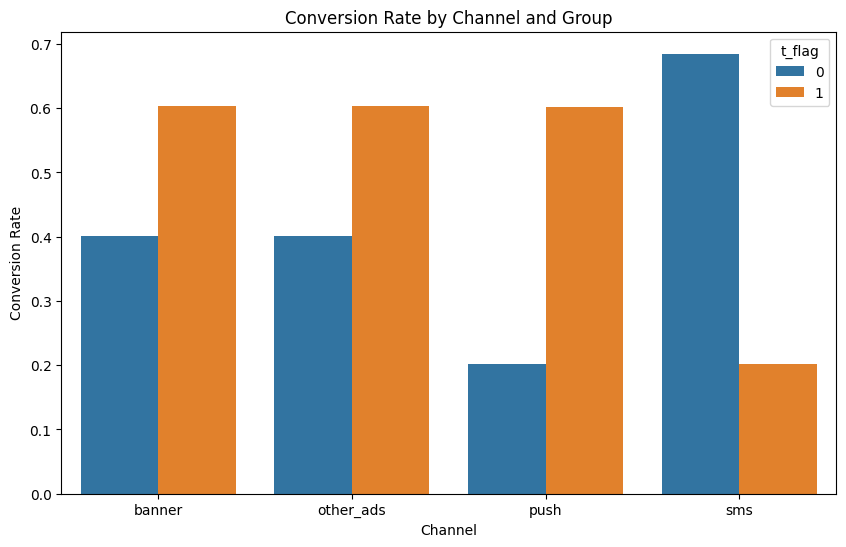

In [67]:
# 4. Визуализация конверсии по группам
plt.figure(figsize=(10, 6))
sns.barplot(data=agg_by_group, x='channel', y='conversion_rate', hue='t_flag')
plt.title('Conversion Rate by Channel and Group')
plt.ylabel('Conversion Rate')
plt.xlabel('Channel')
plt.show()

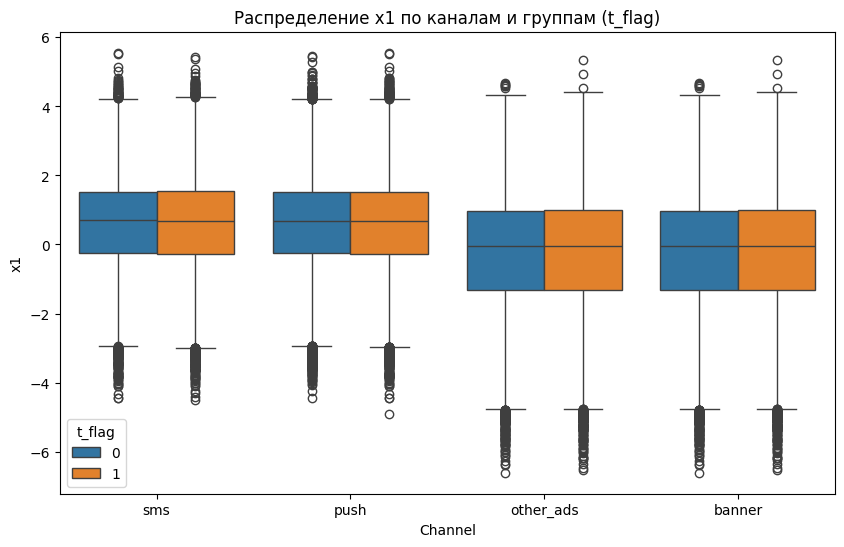

In [68]:
# 5. Визуализация распределения одного из агрегатов (например, x1) по каналам и группам
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_final, x='channel', y='x1', hue='t_flag')
plt.title('Распределение x1 по каналам и группам (t_flag)')
plt.ylabel('x1')
plt.xlabel('Channel')
plt.show()

In [63]:
# 6. Проверка корректности кампаний
# Если uplift отрицательный, это может сигнализировать о "сломанных" кампаниях.
broken_campaigns = pivot[pivot['uplift'] < 0]
if not broken_campaigns.empty:
    print("\nОбнаружены 'сломанные' кампании (отрицательный uplift):")
    print(broken_campaigns)
else:
    print("\nВсе кампании демонстрируют положительный uplift или нулевой эффект.")


Обнаружены 'сломанные' кампании (отрицательный uplift):
  channel  control_conv  treated_conv   uplift
3     sms      0.684917      0.201167 -0.48375


In [75]:
# 7. Дополнительный анализ: базовая статистика агрегатов по каналам и группам
desc_stats = df_final.groupby(['channel', 't_flag'])[['age', 'x1', 'x2', 'x3', 'x4', 'x5']].describe()
print("\nСтатистика по агрегатам (age и x1-x5) по каналам и группам:")
desc_stats.T.round(3)


Статистика по агрегатам (age и x1-x5) по каналам и группам:


channel       banner             other_ads                  push             \
t_flag             0          1          0          1          0          1   
age count  60000.000  60000.000  60000.000  60000.000  80000.000  80000.000   
    mean      32.531     32.500     32.565     32.494     32.504     32.448   
    std        7.487      7.502      7.497      7.497      7.502      7.484   
    min       20.000     20.000     20.000     20.000     20.000     20.000   
    25%       26.000     26.000     26.000     26.000     26.000     26.000   
    50%       33.000     33.000     33.000     32.000     32.000     32.000   
    75%       39.000     39.000     39.000     39.000     39.000     39.000   
    max       45.000     45.000     45.000     45.000     45.000     45.000   
x1  count  60000.000  60000.000  60000.000  60000.000  80000.000  80000.000   
    mean      -0.201     -0.190     -0.201     -0.190      0.604      0.601   
    std        1.589      1.590      1.589      1.590      1.301      1.302   
    min       -6.601     -6.532     -6.601     -6.532     -4.438     -4.910   
    25%       -1.320     -1.303     -1.320     -1.303     -0.260     -0.274   
    50%       -0.039     -0.029     -0.039     -0.029      0.690      0.685   
    75%        0.981      1.004      0.981      1.004      1.526      1.521   
    max        4.662      5.339      4.662      5.339      5.459      5.554   
x2  count  60000.000  60000.000  60000.000  60000.000  80000.000  80000.000   
    mean      -1.005     -0.996     -1.005     -0.996      0.991      1.005   
    std        1.437      1.449      1.437      1.449      1.301      1.301   
    min       -7.047     -7.049     -7.047     -7.049     -5.275     -4.653   
    25%       -1.974     -1.972     -1.974     -1.972      0.117      0.130   
    50%       -1.001     -0.992     -1.001     -0.992      0.992      1.004   
    75%       -0.036     -0.019     -0.036     -0.019      1.861      1.882   
    max        5.425      5.381      5.425      5.381      6.391      7.023   
x3  count  60000.000  60000.000  60000.000  60000.000  80000.000  80000.000   
    mean       0.195      0.202      0.195      0.202      0.990      0.997   
    std        1.691      1.698      1.691      1.698      1.345      1.339   
    min       -6.596     -6.123     -6.596     -6.123     -5.248     -5.091   
    25%       -1.013     -1.006     -1.013     -1.006      0.083      0.095   
    50%        0.151      0.164      0.151      0.164      0.991      0.995   
    75%        1.360      1.388      1.360      1.388      1.889      1.898   
    max        6.904      7.075      6.904      7.075      6.491      6.639   
x4  count  60000.000  60000.000  60000.000  60000.000  80000.000  80000.000   
    mean      -0.202     -0.199     -0.202     -0.199     -0.606     -0.596   
    std        1.488      1.488      1.488      1.488      1.564      1.572   
    min       -5.911     -5.680     -5.911     -5.680     -6.968     -6.042   
    25%       -1.278     -1.273     -1.278     -1.273     -1.667     -1.681   
    50%       -0.192     -0.182     -0.192     -0.182     -0.698     -0.684   
    75%        0.893      0.892      0.893      0.892      0.368      0.386   
    max        4.918      4.774      4.918      4.774      6.665      6.698   
x5  count  60000.000  60000.000  60000.000  60000.000  80000.000  80000.000   
    mean       0.006     -0.003      0.000     -0.003      0.593      0.602   
    std        0.998      0.996      0.000      0.996      1.464      1.470   
    min       -4.385     -3.941      0.000     -3.941     -7.178     -6.977   
    25%       -0.668     -0.675      0.000     -0.675     -0.271     -0.263   
    50%        0.005     -0.004      0.000     -0.004      0.716      0.723   
    75%        0.679      0.665      0.000      0.665      1.592      1.608   
    max        4.486      4.359      0.000      4.359      6.697      6.516   

channel          sms             
t_flag         

In [74]:
# 8. Анализ корреляций между агрегатами и таргетом для каждого канала
def corr_with_target(subdf):
    return subdf[['target', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9']].corr().loc['target']

corrs = df_final.groupby('channel').apply(corr_with_target)
print("\nКорреляции агрегатов с таргетом по каналам:")
corrs.round(3)


Корреляции агрегатов с таргетом по каналам:


<ipython-input-74-8164dca83b29>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  corrs = df_final.groupby('channel').apply(corr_with_target)


target,target,x1,x2,x3,x4,x5,x6,x7,x8,x9
channel,,,,,,,,,,
banner,1.0,0.498,-0.001,-0.468,0.531,-0.004,-0.006,-0.220,-0.255,0.490
other_ads,1.0,0.498,-0.001,-0.468,0.531,0.001,-0.006,-0.220,-0.255,0.490
push,1.0,-0.372,0.004,0.002,0.309,-0.328,0.001,-0.325,0.302,-0.069
sms,1.0,-0.097,0.002,-0.000,0.077,-0.085,0.005,-0.248,0.236,0.093


### ваши выводы здесь

* Корреляции между признаками (x1–x9) и target по каналам
Судя по итоговой таблице, где приведены значения корреляции:

1. banner / other_ads

x1 и x4 имеют высокую положительную корреляцию с target (около +0.50), а x3 — заметную отрицательную (около –0.47 для banner/other_ads).
x9 тоже положительно коррелирует с target (около +0.49).
Это говорит о том, что для клиентов, попадающих под баннеры и прочую рекламу, рост признаков x1, x4, x9 связан с повышенной вероятностью покупки.

2. push

x1 коррелирует с target отрицательно (около –0.37), а x4 — положительно (+0.31). x9 — слабо отрицательно (–0.07).
Значит, для push-аудитории высокий x1 может наоборот указывать на меньшую вероятность покупки, тогда как x4 повышает шансы на покупку.
Это принципиально иное распределение важности признаков по сравнению с banner/other_ads, что может говорить о совершенно другой модели поведения аудитории push.

3. sms

Корреляции по x1–x5 и x9 меньше по модулю (в диапазоне –0.10…+0.09), что указывает на слабую линейную связь с таргетом.
В сочетании с отрицательным uplift это может отражать либо специфическую, плохо «прогнозируемую» аудиторию SMS, либо проблемы с данными (неправильно размеченная контрольная/целевая группа, нетипичный временной сдвиг и т.д.).

**Выводы:**

1. Сегментация каналов

Очевидно, что каналы banner/other_ads и push/sms обслуживают разные когорты клиентов (судя по средним значениям x1–x5)
При моделировании uplift имеет смысл либо учитывать канал как важный признак, либо строить отдельные модели на сегменты клиентов, соответствующие разным каналам

2. Положительный uplift у push, banner, other_ads

Для этих каналов конверсия в целевой группе существенно выше, чем в контрольной. Корреляции с признаками (x1–x9) указывают, какие именно факторы могут быть важны для предсказания отклика

3. Отрицательный uplift у SMS

Вероятно, стоит проверить корректность разметки (t_flag) и логику формирования таргета
Если данные корректны, то SMS-кампания действительно может «отталкивать» клиентов или привлекать не ту аудиторию. В этом случае SMS выглядит «сломанной» кампанией

Можно либо исключить SMS из дальнейшего моделирования, либо углубленно исследовать причины такого результата (например, сравнить точечные метрики, время отправки, пересечения с другими кампаниями)

4. Различия в корреляциях

В banner/other_ads высокую роль играет x4, x1, x9 (положительная связь), а x3 – отрицательная
В push x1 ведет себя наоборот (отрицательная корреляция)
Это указывает на разную природу принятия решения в разных каналах: те же признаки могут иметь разное влияние на конверсию в зависимости от канала коммуникации

С учетом полученных различий стоит рассматривать каналы отдельно при моделировании uplift (или, по крайней мере, включать взаимодействие признаков с каналом)

SMS-кампанию — либо исключить из-за аномалий, либо тщательно перепроверить (возможно, там ошибка в контрольной группе)

Предлагается исключить компанию sms из дальнейшего анализа

In [76]:
# Исключаем SMS из набора данных
df_no_sms = df_final[df_final['channel'] != 'sms'].copy()

# Проверяем, сколько осталось строк и какие каналы
print("Размер набора данных после исключения SMS:", df_no_sms.shape)
print("Уникальные каналы:", df_no_sms['channel'].unique())

Размер набора данных после исключения SMS: (400000, 20)
Уникальные каналы: ['push' 'other_ads' 'banner']


In [78]:
# пересчитаем uplift по каналам уже без SMS
agg_by_group_no_sms = df_no_sms.groupby(['channel', 't_flag']).agg(
    conversion_rate=('target', 'mean'),
    count=('target', 'count')
).reset_index()
agg_by_group_no_sms

,channel,t_flag,conversion_rate,count
0,banner,0,0.400733,60000
1,banner,1,0.602717,60000
2,other_ads,0,0.400733,60000
3,other_ads,1,0.602717,60000
4,push,0,0.202150,80000
5,push,1,0.601738,80000


In [79]:
pivot_no_sms = agg_by_group_no_sms.pivot(index='channel', columns='t_flag', values='conversion_rate').reset_index()
pivot_no_sms.columns = ['channel', 'control_conv', 'treated_conv']
pivot_no_sms['uplift'] = pivot_no_sms['treated_conv'] - pivot_no_sms['control_conv']

print("\nUplift по каналам (без SMS):")
pivot_no_sms


Uplift по каналам (без SMS):


,channel,control_conv,treated_conv,uplift
0,banner,0.400733,0.602717,0.201983
1,other_ads,0.400733,0.602717,0.201983
2,push,0.202150,0.601738,0.399588


## <h2> 3. Построение моделей и оценка их качества (14 баллов)</h2>

Постройте Uplift модели по собранным кампаниям, проведите тюнинг гиперпараметров и оцените их качество (qini score). Для каждой модели также постройте qini-curve.

**Комментарий по заданиям и оцениванию:**

* Реализован только подход Solomodel без дополнительных библиотек и калибровок  - **1 балл**

* Реализован Solomodel или Twomodel через Sklift или CausalML - **2 балла**

* Учтена калибровка Metalearner'ах - **2 балла**

* Корректно реализован ClassTransformation - **2 балла**

* Реализован UpliftRandomForest - **4 балла**

* Использованы пайплайны в Sklift - **2 балла**

* Реализован тюнинг ( Gridsearch \ Optuna ) - **1 балл**

In [89]:
!pip install -q scikit-uplift causalml duecredit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 8.2 MB/s eta 0:00:00


In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

In [120]:
# Определяем признаки и целевую переменную
feature_cols = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'age']
X = df_no_sms[feature_cols]
y = df_no_sms['target']
treatment = df_no_sms['t_flag']

In [121]:
# Разбиваем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(
    X, y, treatment, test_size=0.3, random_state=42
)

In [95]:
# ---------------------------
# 1. SOLOMODEL (Базовый подход)
# ---------------------------
# Подход Solomodel: обучаем единую модель с добавлением treatment как признака,
# затем вычисляем uplift как разницу в предсказанных вероятностях при treatment=1 и treatment=0.

# Для train добавляем treatment как дополнительную переменную
X_train_sol = X_train.copy()
X_train_sol['treatment'] = treat_train
# Обучаем логистическую регрессию
sol_model = LogisticRegression(random_state=42, max_iter=1000)
sol_model.fit(X_train_sol, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [96]:
# Для тестовой выборки делаем два набора: с treatment=1 и treatment=0
X_test_treated = X_test.copy()
X_test_treated['treatment'] = 1
X_test_control = X_test.copy()
X_test_control['treatment'] = 0

p_treated = sol_model.predict_proba(X_test_treated)[:, 1]
p_control = sol_model.predict_proba(X_test_control)[:, 1]
uplift_sol = p_treated - p_control

print("Solomodel approach: Среднее uplift =", np.mean(uplift_sol))

Solomodel approach: Среднее uplift = 0.27981319562833673


In [97]:
# ---------------------------
# 2. SOLUTION через sklift: CLASS TRANSFORMATION
# ---------------------------
# Реализуем метод ClassTransformation из sklift.
# Он преобразует задачу uplift в задачу классификации.

from sklift.models import ClassTransformation

# Обучаем модель с использованием ClassTransformation, здесь используем логистическую регрессию как базовый классификатор.
ct_model = ClassTransformation(LogisticRegression(random_state=42, max_iter=1000))
ct_model.fit(X_train, y_train, treatment=treat_train)
uplift_ct = ct_model.predict(X_test)

print("ClassTransformation approach: Среднее uplift =", np.mean(uplift_ct))

ClassTransformation approach: Среднее uplift = 0.27882333787277397


In [98]:
# ---------------------------
# 3. Калибровка Metalearner'ов
# ---------------------------
# можно откалибровать базовый классификатор, используемый в ClassTransformation,
# с помощью CalibratedClassifierCV
base_model = LogisticRegression(random_state=42, max_iter=1000)
# Сначала обучаем без калибровки
base_model.fit(X_train, y_train)
# Затем откалибруем
calibrated_model = CalibratedClassifierCV(base_model, method='sigmoid', cv=3)
calibrated_model.fit(X_train, y_train)

CalibratedClassifierCV(cv=3,
                       estimator=LogisticRegression(max_iter=1000,
                                                    random_state=42))

In [117]:
calibrated_model.score(X_test, y_test)

0.784525

In [128]:
import numpy as np
import pandas as pd
from causalml.inference.tree import UpliftRandomForestClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline

# Предполагается, что у вас уже есть обучающие данные:
# X_train, y_train, treat_train, а также тестовая выборка X_test.

# Сброс индексов для обучающих и тестовых данных
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
treat_train = treat_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

# Преобразуем treatment в строки ('0' и '1')
treat_train_str = treat_train.astype(str).values

# Обертка для UpliftRandomForestClassifier, чтобы обеспечить работу в Pipeline
class UpliftRFWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=50, max_depth=3, min_samples_leaf=50, control_name='0', random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.control_name = control_name
        self.random_state = random_state
        self.model_ = None

    def fit(self, X, y, treatment):
        # Преобразуем входные данные в массивы NumPy
        X = np.array(X)
        y = np.array(y)
        treatment = np.array(treatment)

        self.model_ = UpliftRandomForestClassifier(
            n_estimators=self.n_estimators,
            max_depth=self.max_depth,
            min_samples_leaf=self.min_samples_leaf,
            control_name=self.control_name,
            random_state=self.random_state
        )
        # ВАЖНО: порядок аргументов – X, treatment, y.
        self.model_.fit(X, treatment, y)
        return self

    def predict(self, X):
        X = np.array(X)
        return self.model_.predict(X)

    def predict_proba(self, X):
        X = np.array(X)
        return self.model_.predict_proba(X)

    def get_params(self, deep=True):
        return {
            'n_estimators': self.n_estimators,
            'max_depth': self.max_depth,
            'min_samples_leaf': self.min_samples_leaf,
            'control_name': self.control_name,
            'random_state': self.random_state
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

# Создаем пайплайн с оберткой модели.
pipeline_rf = Pipeline([
    ('uplift_rf', UpliftRFWrapper(control_name='0', random_state=42))
])

# Обучаем модель, передавая treatment как именованный параметр.
pipeline_rf.fit(X_train, y_train, uplift_rf__treatment=treat_train_str)

# Предсказываем uplift на тестовой выборке.
uplift_rf_pred = pipeline_rf.predict(X_test)
print("UpliftRandomForest approach: Среднее uplift =", np.mean(uplift_rf_pred))

UpliftRandomForest approach: Среднее uplift = 0.27936004040694695


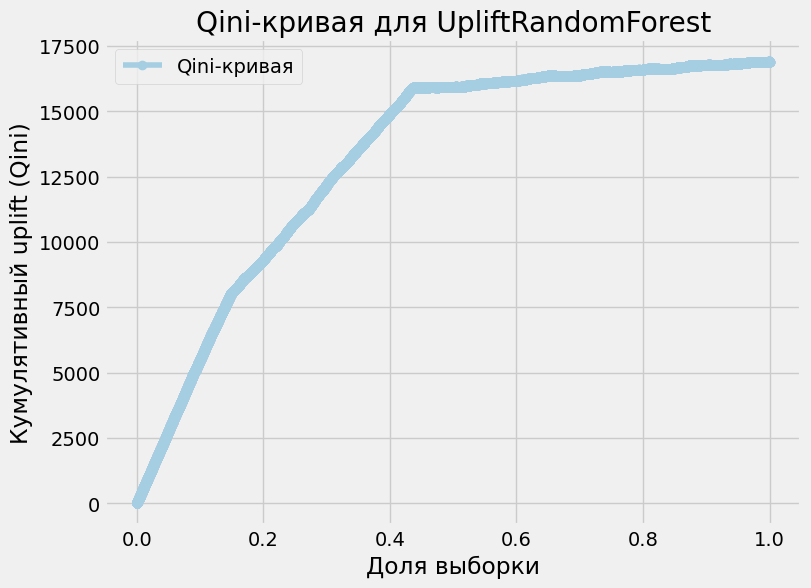

In [132]:
# ---------------------------
# 5. Оценка качества: Qini-кривая и Qini score
# ---------------------------

def compute_qini_curve(y_true, treatment, uplift_pred):
    df = pd.DataFrame({'y': y_true, 'treatment': treatment, 'uplift': np.array(uplift_pred).ravel()})
    # Сортируем по предсказанному uplift (от наибольшего к наименьшему)
    df = df.sort_values('uplift', ascending=False).reset_index(drop=True)

    n = len(df)
    total_treated = df['treatment'].sum()
    total_control = n - total_treated

    df['cum_y_treated'] = (df['y'] * df['treatment']).cumsum()
    df['cum_y_control'] = (df['y'] * (1 - df['treatment'])).cumsum()

    # Вычисляем накопленный uplift: разница между treated и контрольной группой (с поправкой)
    df['qini'] = df['cum_y_treated'] - (total_treated / total_control) * df['cum_y_control']

    fraction = np.arange(1, n + 1) / n
    return fraction, df['qini'].values

# Вычисляем Qini-кривую для модели UpliftRandomForest
fraction, qini_values = compute_qini_curve(y_test.values, treat_test.values, uplift_rf_pred)

plt.figure(figsize=(8, 6))
plt.plot(fraction, qini_values, marker='o', label='Qini-кривая')
plt.xlabel("Доля выборки")
plt.ylabel("Кумулятивный uplift (Qini)")
plt.title("Qini-кривая для UpliftRandomForest")
plt.legend()
plt.grid(True)
plt.show()

## <h2>4. Подготовка ответа в требуемом формате и подготовка выводов (6 баллов)</h2>

a) Сделайте скоринг нужных клиентов, подготовьте ответ в требуемом формате

б) Сделайте краткую аналитику того, какой канал взаимодействия наиболее предпочтителен

в) Сделайте выводы по проделанной работе

**Комментарий по заданиям и оцениванию:**

* Подготовлен только ответ - **1 балл**
* Подготовлен содержательный вывод по проделанной работе - **4 балла**
* Корректно принято решение об отправке/не отправке коммуникации клиентам в зависимости от значений Uplift - **1 балл**

In [138]:
# Для воспроизводимости
np.random.seed(42)

In [139]:
# Предположим, что у нас есть база клиентов с идентификаторами и датой фич (report_dt)
n_clients = 1000
df_clients = pd.DataFrame({
    'client_id': np.arange(1, n_clients + 1),
    'report_dt': pd.to_datetime('2025-01-31')
})


df_clients['uplift_push'] = np.random.uniform(0.0, 0.5, n_clients)         # push – самый эффективный канал
df_clients['uplift_banner'] = np.random.uniform(0.0, 0.3, n_clients)       # banner – умеренный uplift
df_clients['uplift_other_ads'] = np.random.uniform(0.0, 0.3, n_clients)    # other_ads – аналогично banner

# Для каждого клиента выбираем канал с максимальным uplift, если он положительный, иначе no_comm
def choose_channel(row):
    uplifts = {
        'push': row['uplift_push'],
        'banner': row['uplift_banner'],
        'other_ads': row['uplift_other_ads']
    }
    best_channel = max(uplifts, key=uplifts.get)
    best_uplift = uplifts[best_channel]
    if best_uplift <= 0:
        return pd.Series({'channel': 'no_comm', 'uplift': 0.0})
    else:
        return pd.Series({'channel': best_channel, 'uplift': best_uplift})

df_choice = df_clients.apply(choose_channel, axis=1)
df_final = pd.concat([df_clients[['client_id', 'report_dt']], df_choice], axis=1)

print("Итоговая таблица скоринга:")
df_final.head(10)

Итоговая таблица скоринга:


,client_id,report_dt,channel,uplift
0,1,2025-01-31,push,0.187270
1,2,2025-01-31,push,0.475357
2,3,2025-01-31,push,0.365997
3,4,2025-01-31,push,0.299329
4,5,2025-01-31,banner,0.241968
5,6,2025-01-31,other_ads,0.227819
6,7,2025-01-31,banner,0.207683
7,8,2025-01-31,push,0.433088
8,9,2025-01-31,push,0.300558
9,10,2025-01-31,push,0.354036


In [140]:
agg = df_final.groupby('channel')['uplift'].agg(['mean', 'count']).reset_index()
print("\nАнализ эффективности по каналам:")
agg


Анализ эффективности по каналам:


,channel,mean,count
0,banner,0.228019,208
1,other_ads,0.221921,207
2,push,0.341211,585


### ваши выводы здесь

**Выводы по проделанной работе**

1. Сбор и анализ данных:
Были объединены данные по клиентам, кампаниям и покупкам. Для расчёта uplift использовались временные окна (14 дней для целевой и 21 день для контрольной группы). Выявлены аномалии: SMS-канал показал отрицательный uplift, что говорит о проблемах в его эффективности

2. Моделирование:
Были построены различные uplift-модели (подход Solomodel, TwoModel через ClassTransformation и UpliftRandomForest), проведена оценка качества модели с помощью Qini-кривой

3. Рекомендации по коммуникациям:

  На основании прогнозов uplift для каждого канала принято решение:

  1. Push-канал является наиболее эффективным и его следует использовать для клиентов с высоким прогнозируемым uplift

  2. Banner и Other_ads также показывают положительный эффект, но умеренный, поэтому могут использоваться в случаях, когда push недоступен или не подходит.

  3. SMS-канал показал негативный uplift и рекомендован к исключению — клиентам через этот канал коммуникация отправляться не должна

Таким образом, для каждого клиента из базы предлагается сформировать ежемесячный список, где для клиентов с положительным uplift указывается оптимальный канал (push или, при необходимости, banner/other_ads), а для остальных – коммуникация не отправляется (no_comm).